In [2]:
import sys
import os
sys.path.append('..')

from utils import *
from config import *

In [18]:
attack_name_list = ['attack_sam_k', 'AA', 'PATA', 'PATA++', 'UAD']
epsilon_list = [4, 8, 12, 16]
iou_list = []
attacker_mean = []
attacker_asr50 = []
for aid, attack_name in enumerate(attack_name_list):
    iou_list.append([])
    attacker_mean.append([])
    attacker_asr50.append([])
    for eid, epsilon in enumerate(epsilon_list):
        iou_list[aid].append([])
        evaluator_list = ['fastsam', 'samb', 'saml', 'samh']
        log_folder = f"{PROJECT_PATH}/exp/log/epsilon/{attack_name}_eps_{epsilon}/"
        for imgid in range(1, 41):
            result_json_file_name = f"{log_folder}{imgid}_{attack_name}.json"
            if os.path.exists(result_json_file_name):
                with open(result_json_file_name, 'r') as f:
                    results = json.load(f)
                    evaluations = results['evaluations']
                    for prompt_uid, prompt_result in evaluations.items():
                        iou = prompt_result['samb']
                        iou_list[aid][eid].append(iou)
            else:
                #print(f"File {result_json_file_name} does not exist")
                continue
    
    print(f"Evaluation results for {attack_name}:")
    
    for eid, epsilon in enumerate(epsilon_list):
        iou_evaluator = iou_list[aid][eid]
        iou_mean = np.mean(iou_evaluator)
        iou_std = np.std(iou_evaluator)
        asr_50 = np.sum(np.array(iou_evaluator) <= 50) / len(iou_evaluator) * 100
        asr_10 = np.sum(np.array(iou_evaluator) <= 10) / len(iou_evaluator) * 100
        print(f"Epsilon={epsilon} - {iou_mean:.2f}+-{iou_std:.2f} - ASR@50: {asr_50:.2f} - ASR@10: {asr_10:.2f}")
        attacker_mean[aid].append(iou_mean)
        attacker_asr50[aid].append(asr_50)
    attacker_mean[aid] = np.array(attacker_mean[aid])
    attacker_asr50[aid] = np.array(attacker_asr50[aid])

Evaluation results for attack_sam_k:
Epsilon=4 - 75.12+-25.62 - ASR@50: 17.72 - ASR@10: 3.47
Epsilon=8 - 68.87+-28.36 - ASR@50: 24.22 - ASR@10: 5.72
Epsilon=12 - 67.54+-29.00 - ASR@50: 25.47 - ASR@10: 7.50
Epsilon=16 - 66.45+-28.72 - ASR@50: 26.28 - ASR@10: 7.34
Evaluation results for AA:
Epsilon=4 - 73.98+-27.21 - ASR@50: 19.22 - ASR@10: 4.56
Epsilon=8 - 64.22+-30.51 - ASR@50: 30.25 - ASR@10: 9.09
Epsilon=12 - 57.10+-33.42 - ASR@50: 37.75 - ASR@10: 15.50
Epsilon=16 - 49.06+-32.80 - ASR@50: 47.00 - ASR@10: 19.69
Evaluation results for PATA:
Epsilon=4 - 75.07+-26.35 - ASR@50: 17.34 - ASR@10: 4.25
Epsilon=8 - 64.36+-30.85 - ASR@50: 29.44 - ASR@10: 9.31
Epsilon=12 - 54.50+-32.85 - ASR@50: 41.62 - ASR@10: 15.53
Epsilon=16 - 48.79+-33.02 - ASR@50: 47.59 - ASR@10: 21.16
Evaluation results for PATA++:
Epsilon=4 - 74.45+-27.06 - ASR@50: 18.06 - ASR@10: 5.12
Epsilon=8 - 66.38+-30.30 - ASR@50: 27.84 - ASR@10: 8.50
Epsilon=12 - 54.96+-32.78 - ASR@50: 40.28 - ASR@10: 16.03
Epsilon=16 - 50.36+-33.1

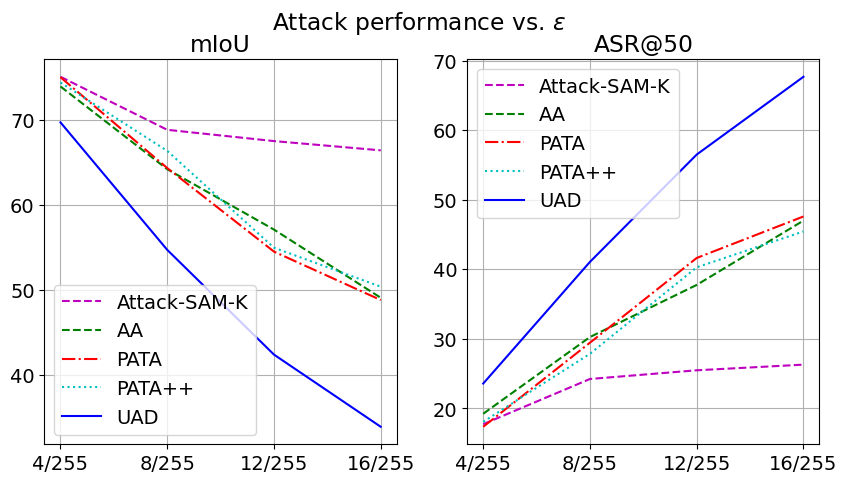

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 横坐标
x_values = np.array(epsilon_list) / 255

# 设置线条样式列表
line_styles = ['--', '--', '-.', ':', '-']

# 设置颜色列表
colors = ['m', 'g', 'r', 'c', 'b']

# 创建一个带有两个子图（1行2列）的图表
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# 定义一个画线的函数
def plot_lines(ax, x_values, arrays, line_styles, colors, labels):
    for arr, style, color, label in zip(arrays, line_styles, colors, labels):
        ax.plot(x_values, arr, style, color=color, label=label)
    ax.set_xticks(x_values)
    ax.set_xticklabels([f'{x:.3f}' for x in x_values])
    ax.legend()
    ax.grid(True)

# 用于图例的标签列表
labels = ['Attack-SAM-K', 'AA', 'PATA', 'PATA++' , 'UAD']

# 在两个子图上分别画线
plot_lines(ax1, x_values, attacker_mean, line_styles, colors, labels)
plot_lines(ax2, x_values, attacker_asr50, line_styles, colors, labels)

# 设置子图的标题
ax1.set_title('mIoU')
ax1.set_xticklabels(['4/255', '8/255', '12/255', '16/255'])
ax2.set_title('ASR@50')
ax2.set_xticklabels(['4/255', '8/255', '12/255', '16/255'])

# 设置全局标题
plt.rcParams.update({'font.size': 14})
plt.suptitle(r'Attack performance vs. $\epsilon$')
plt.savefig(f"{PROJECT_PATH}/exp/attack_performance_vs_epsilon.pdf")

# 显示图表
plt.show()